In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

# Function to unpickle the CIFAR-10 dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load CIFAR-10 dataset
data_batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
data_batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
data_batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
data_batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
data_batch_5 = unpickle('cifar-10-batches-py/data_batch_5')
test_batch = unpickle('cifar-10-batches-py/test_batch')

In [16]:
# Combine the training batches
x_train = np.concatenate([data_batch_1[b'data'], data_batch_2[b'data'], data_batch_3[b'data'],
                          data_batch_4[b'data'], data_batch_5[b'data']], axis=0)
y_train = np.concatenate([data_batch_1[b'labels'], data_batch_2[b'labels'], data_batch_3[b'labels'],
                          data_batch_4[b'labels'], data_batch_5[b'labels']], axis=0)

# Reshape the data to include timesteps dimension
x_train = x_train.reshape((len(x_train), 1, 32, 32, 3))
y_train = np.array(y_train)

# Preprocess the data
x_train = x_train.astype('float32') / 255.0

In [ ]:
def skew(inputs, scope="skew"):
  with tf.name_scope(scope):
    batch, height, width, channel = get_shape(inputs) # [batch, height, width, channel]
    rows = tf.split(1, height, inputs) # [batch, 1, width, channel]

    new_width = width + height - 1
    new_rows = []

    for idx, row in enumerate(rows):
      transposed_row = tf.transpose(tf.squeeze(row, [1]), [0, 2, 1]) # [batch, channel, width]
      squeezed_row = tf.reshape(transposed_row, [-1, width]) # [batch*channel, width]
      padded_row = tf.pad(squeezed_row, ((0, 0), (idx, height - 1 - idx))) # [batch*channel, width*2-1]

      unsqueezed_row = tf.reshape(padded_row, [-1, channel, new_width]) # [batch, channel, width*2-1]
      untransposed_row = tf.transpose(unsqueezed_row, [0, 2, 1]) # [batch, width*2-1, channel]

      assert get_shape(untransposed_row) == [batch, new_width, channel], "wrong shape of skewed row"
      new_rows.append(untransposed_row)

    outputs = tf.pack(new_rows, axis=1, name="output")
    assert get_shape(outputs) == [None, height, new_width, channel], "wrong shape of skewed output"

  logger.debug('[skew] %s : %s %s -> %s %s' \
      % (scope, inputs.name, inputs.get_shape(), outputs.name, outputs.get_shape()))
  return outputs

In [ ]:

def unskew(inputs, width=None, scope="unskew"):
  with tf.name_scope(scope):
    batch, height, skewed_width, channel = get_shape(inputs)
    width = width if width else height

    new_rows = []
    rows = tf.split(1, height, inputs)

    for idx, row in enumerate(rows):
      new_rows.append(tf.slice(row, [0, 0, idx, 0], [-1, -1, width, -1]))
    outputs = tf.concat(1, new_rows, name="output")

  logger.debug('[unskew] %s : %s %s -> %s %s' \
      % (scope, inputs.name, inputs.get_shape(), outputs.name, outputs.get_shape()))
  return outputs

In [17]:
# Define the Diagonal BiLSTM model
class DiagonalLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(DiagonalLSTMCell, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1] + self.units, 4 * self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units, 4 * self.units),
                                                initializer='uniform',
                                                name='recurrent_kernel')
        self.bias = self.add_weight(shape=(4 * self.units,),
                                    initializer='zeros',
                                    name='bias')

    def call(self, inputs, states):
        h_prev, c_prev = states
        inputs_concat = tf.concat([h_prev, inputs], axis=-1)
        gate_inputs = tf.matmul(inputs_concat, self.kernel) + tf.matmul(h_prev, self.recurrent_kernel) + self.bias

        i, f, o, g = tf.split(gate_inputs, 4, axis=-1)
        i = tf.sigmoid(i)
        f = tf.sigmoid(f)
        o = tf.sigmoid(o)
        g = tf.tanh(g)

        c = f * c_prev + i * g
        h = o * tf.tanh(c)
        return h, [h, c]

In [18]:
class DiagonalLSTM(tf.keras.layers.Layer):
    def __init__(self, units):
        super(DiagonalLSTM, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.cell = DiagonalLSTMCell(self.units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        output_dim = inputs.shape[2]

        # Initialize initial hidden state and cell state
        initial_state = tf.zeros((batch_size, self.units))
        initial_state = [initial_state, initial_state]

        # Iterate through time steps
        outputs = tf.TensorArray(dtype=tf.float32, size=time_steps)
        states = initial_state
        for t in range(time_steps):
            x_t = tf.roll(inputs[:, t, :], shift=-t, axis=1)  # Skewing input along rows
            h_t, states = self.cell(x_t, states)
            outputs = outputs.write(t, h_t)
        outputs = tf.transpose(outputs.stack(), [1, 0, 2])
        return outputs

In [19]:
# Define the Diagonal BiLSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), input_shape=(1, 32, 32, 3)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2))),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2))),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (1, 1), activation='relu')),  # k x 1 convolution
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),  # Removed extra parenthesis
    DiagonalLSTM(64),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
782/782 [==============================] - 13s 17ms/step - loss: 1.6934 - accuracy: 0.1041
Epoch 2/10
782/782 [==============================] - 12s 15ms/step - loss: 1.3873 - accuracy: 0.1062
Epoch 3/10
782/782 [==============================] - 12s 15ms/step - loss: 1.2528 - accuracy: 0.1069
Epoch 4/10
782/782 [==============================] - 12s 15ms/step - loss: 1.1454 - accuracy: 0.1082
Epoch 5/10
782/782 [==============================] - 13s 16ms/step - loss: 1.0695 - accuracy: 0.1079
Epoch 6/10
782/782 [==============================] - 12s 15ms/step - loss: 1.0007 - accuracy: 0.1086
Epoch 7/10
782/782 [==============================] - 12s 15ms/step - loss: 0.9456 - accuracy: 0.1089
Epoch 8/10
782/782 [==============================] - 12s 15ms/step - loss: 0.8878 - accuracy: 0.1091
Epoch 9/10
782/782 [==============================] - 12s 15ms/step - loss: 0.8343 - accuracy: 0.1096
Epoch 10/10
782/782 [==============================] - 12s 15ms/step - loss: 0.783

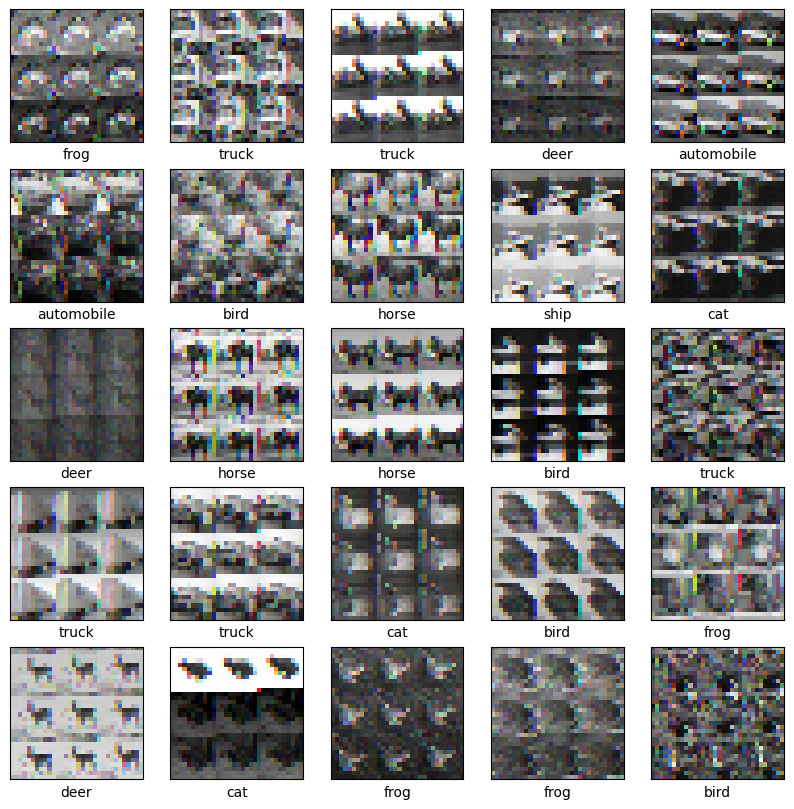

In [21]:
# Define the CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Display sample images after training
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i, 0], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])  # Use class names instead of integer labels
plt.show()

In [22]:
# Evaluate the model using log-likelihood
loss, accuracy = model.evaluate(x_train, y_train)

print("Log-Likelihood Loss:", loss)
print("Accuracy:", accuracy)


1563/1563 [==============================] - 5s 3ms/step - loss: 0.6904 - accuracy: 0.1204
Log-Likelihood Loss: 0.6903814673423767
Accuracy: 0.1203555092215538
